# Simple example of statistical analysis applied stomach inervation data

Keywords: stomach spatial analysis, SPARC, Powley Lab

Demonstration of a reproducible data analysis pipeline shared in Jupyter notebook.

## Required R libraries

In [1]:
load.lib<-c("tibble", "magrittr", "readxl", "httr", "png", "ggfortify", "RJSplot", "spatstat", 
            "DT", "scales", "emmeans", "DT", "IRdisplay", "dplyr", "sfsmisc", "png")

install.lib<-load.lib[!load.lib %in% installed.packages()]
for(lib in install.lib) install.packages(lib,dependencies=TRUE)
sapply(load.lib,require,character=TRUE)

also installing the dependencies ‘rbibutils’, ‘spatial’, ‘gss’, ‘stabledist’, ‘gbutils’, ‘Rdpack’, ‘gtools’, ‘caTools’, ‘RSpectra’, ‘fBasics’, ‘fastICA’, ‘cvar’, ‘cyclocomp’, ‘rex’, ‘xmlparsedata’, ‘maps’, ‘gplots’, ‘sandwich’, ‘rARPACK’, ‘cluster’, ‘changepoint’, ‘fGarch’, ‘ggrepel’, ‘glmnet’, ‘KFAS’, ‘lintr’, ‘mapdata’, ‘MSwM’, ‘ROCR’, ‘strucchange’, ‘timeSeries’, ‘vars’, ‘lfda’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘deldir’, ‘polyclip’, ‘spatstat.sparse’, ‘goftest’, ‘tensor’, ‘spatstat.data’, ‘spatstat.geom’, ‘spatstat.random’, ‘spatstat.explore’, ‘spatstat.model’, ‘spatstat.linnet’, ‘spatstat.utils’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘testit’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the depe

tibble  magrittr    readxl      httr       png ggfortify   RJSplot  spatstat 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 
       DT    scales   emmeans        DT IRdisplay     dplyr   sfsmisc       png 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE

In [2]:
system("ls ~/inputs/input_1", intern=TRUE)

Warning message in system("ls ~/inputs/input_1", intern = TRUE):
“running command 'ls ~/inputs/input_1' had status 2”


character(0)
attr(,"status")
[1] 2
attr(,"errmsg")
[1] "Resource temporarily unavailable"

## Load the data

Load the data downloaded from Blackfynn. The data is in the temporaty local root directory.


In [4]:
#####################################################################################
#### Import the XLSX file

tf <-"IMA_analyzed_data-1.xlsx"
spatial.data.long <- read_excel(tf, sheet=1)
spatial.data.circ <- read_excel(tf, sheet=2)

spatial.data.long <- add_column(spatial.data.long, `layer`=factor("lon", levels=c("lon", "circ")))
spatial.data.circ <- add_column(spatial.data.circ, `layer`=factor("circ", levels=c("lon", "circ")))
spatial.data <- dplyr::bind_rows( spatial.data.long, spatial.data.circ )

New names:
• `` -> `...2`


## Display the raw data

In [5]:
spatial.data.dt <- datatable(spatial.data, filter = 'top', options = list(
  pageLength = 10, autoWidth = TRUE, class = 'cell-border stripe'))
saveWidget(spatial.data.dt, 'table1.html', selfcontained = TRUE)
display_html('<iframe src="table1.html" width=100% height=400></iframe>')

In [63]:
write.table(spatial.data, file="~/outputs/output_1/spatial-data.csv", sep=",")
system("ls ~/outputs/output_1/", inter=TRUE)

[1] "spatial-data.csv"

## Pre-preocess the data

Simple data preprocessing required for statistical analysis.

In [64]:
#####################################################################################
#### Take a subset of columns which are relevant for our work

spatial.data.s <- (spatial.data[,c(5,6,11:16,18:20)])
spatial.data.s <- spatial.data.s %>% filter(complete.cases(.))
spatial.data.sub <- (spatial.data[,c(11:16,18:19)])
spatial.data.sub <- add_column(spatial.data.sub, `Layer`=spatial.data$'layer', `Region`=factor(spatial.data$'Region'))
spatial.data.sub <- spatial.data.sub %>% filter(complete.cases(.))


In [65]:
#####################################################################################
#### Transform some features for variance stabilization 

spatial.data.tr <- spatial.data.sub %>% mutate_at(c(1:6), list(log))
spatial.data.tr <- spatial.data.tr %>% mutate_at(c(7:8), list(sqrt))

#####################################################################################

## Simple PCA plot 

The plot shows the overlap between the regions in the feature space. The regions seem to be indistinguishable, which is misleading.

Saving 6.67 x 6.67 in image


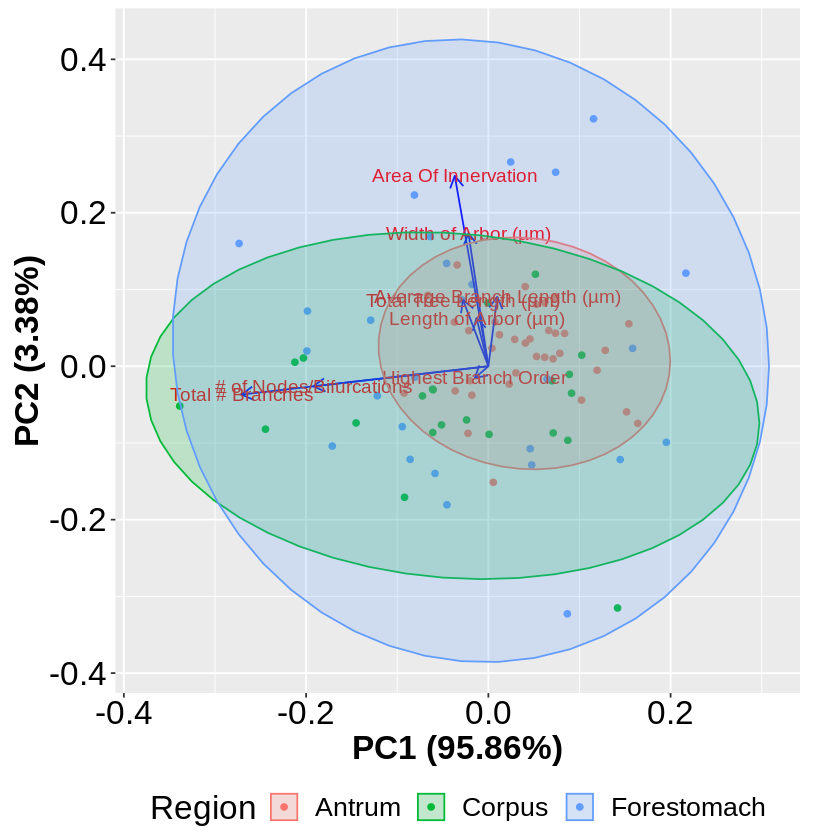

In [66]:
df <- subset(spatial.data.tr[,-c(9,10)], spatial.data.tr$Layer=="circ")
autoplot(prcomp(df), data = subset(spatial.data.tr, Layer=="circ"), colour = 'Region', loadings = TRUE, loadings.colour = 'blue', frame.type = 'norm',
         loadings.label = TRUE, loadings.label.size = 4) + 
  theme(legend.position="bottom", text = element_text(size=20, color = "black"), axis.text.x = element_text(size = 20, color="black"), axis.text.y = element_text(size = 20, color="black"),
        axis.title=element_text(size=20, color = "black", face="bold"), aspect.ratio=1, plot.margin = margin(t = 5, r = 20, b = 5, l = 5, unit = "pt"))
ggsave("PCA_plot.pdf")

## House-keeping (names, defining contrasts, etc.)

In [67]:

cl.names <- c("Area.of.innervation", "Length.of.arbor", "Width.of.arbor", 
              "Total.tree.length", "Highest.branch.order", "Average.branch.length", 
              "Total.no.branches", "No.of.nodes", "Layer", 'Region')

#####################################################################################
#### Convert data from tibble to data.frame (for simplicity)

spatial.data.df <- as.data.frame(spatial.data.sub)
colnames(spatial.data.df) <- cl.names

#####################################################################################
#### Use polynomial contrasts
#### (or other contrasts of your choice inf you are know what you are doing)

contrasts(spatial.data.df$Layer) <- contr.poly(2)
contrasts(spatial.data.df$Region) <- contr.poly(3)


## Density/histogram plots for all the measured features

The heteroskedasticity of the data will be corrected by relevant transformation (log or sqrt). 

In [68]:
#### Custom fedinition of number formating for the plot axes. Ignore!

scientific_10_3 <-
  function(x) {
    ifelse(x==0, "0", 
           ifelse(abs(log10(abs(x))) <= 2, x, sfsmisc::pretty10exp(x, sub10 = T, drop.1 = F))
    )
  }


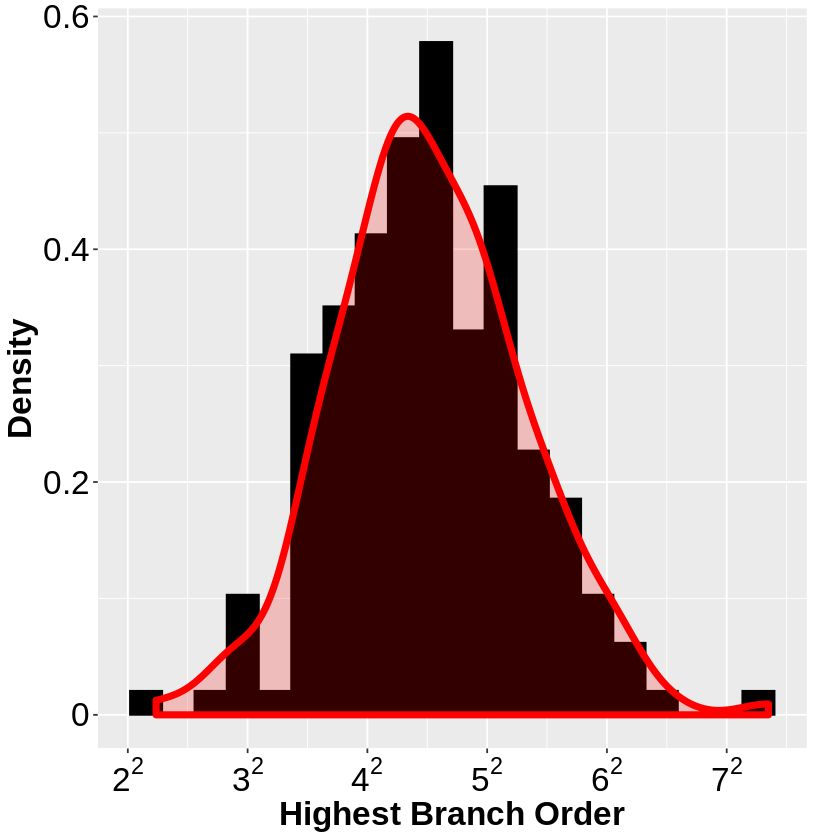

In [69]:
##############################################################################
#### pick i to get other features (numbered). Features available: 5,6,7,8
i = 5 
##############################################################################

x_lab <-
  sapply(colnames(spatial.data.sub)[i], function(x) {
    gsub("\\(µm)", "[µm]", x)
  })
gg_plot <-
  ggplot(data = spatial.data.df, aes((spatial.data.df[[i]]))) +
  geom_histogram(
    aes(y = ..density..),
    col = "black",
    fill = "black",
    bins = 20,
    alpha = 1
  )  +
  geom_density(
    col = 2,
    size = 2,
    fill = 2,
    alpha = .2
  ) +
  theme(
    text = element_text(size = 20, color = "black"),
    axis.text.x = element_text(size = 20, color = "black"),
    axis.text.y = element_text(size = 20, color = "black"),
    axis.title = element_text(size = 20, color = "black", face = "bold"),
    #aspect.ratio = 1,
    plot.margin = margin(
      t = 5,
      r = 20,
      b = 5,
      l = 5,
      unit = "pt"
    )
  ) +
  scale_x_sqrt(
    paste("", x_lab, sep = ""),
    breaks = trans_breaks("sqrt", function(x)
      x ^ 2),
    labels = trans_format("sqrt", math_format(.x ^ 2))
  ) +
  scale_y_continuous("Density", labels = scientific_10_3)

gg_plot  ### print the output

In [70]:
plot.name <- paste(colnames(spatial.data.sub)[i],"-","Distribution density plot.pdf")
plot.name
ggsave(plot.name)

[1] "Highest Branch Order - Distribution density plot.pdf"

Saving 6.67 x 6.67 in image


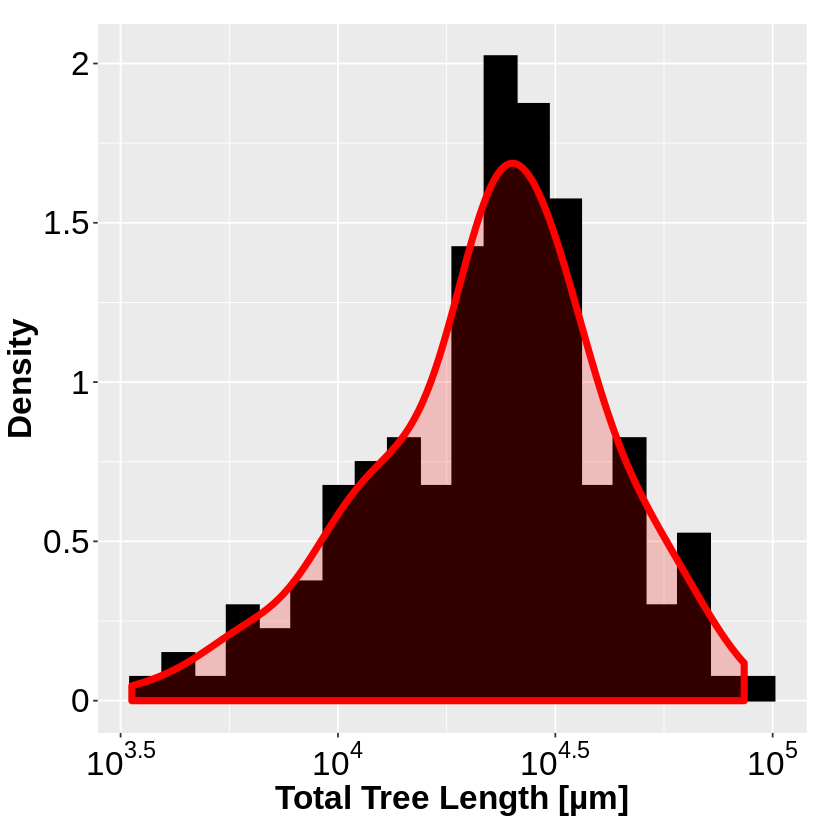

In [71]:
##############################################################################
#### pick i to get other features (numbered). Features available: 1,2,3, and 4
i = 4  
##############################################################################

x_lab <-
  sapply(colnames(spatial.data.sub)[i], function(x) {
    gsub("\\(µm)", "[µm]", x)
  })
gg_plot <-
  ggplot(data = spatial.data.df, aes((spatial.data.df[[i]]))) +
  geom_histogram(
    aes(y = ..density..),
    col = "black",
    fill = "black",
    bins = 20,
    alpha = 1
  )  +
  geom_density(
    col = 2,
    size = 2,
    fill = 2,
    alpha = .2
  ) +
  theme(
    text = element_text(size = 20, color = "black"),
    axis.text.x = element_text(size = 20, color = "black"),
    axis.text.y = element_text(size = 20, color = "black"),
    axis.title = element_text(size = 20, color = "black", face = "bold"),
    aspect.ratio = 1,
    plot.margin = margin(
      t = 5,
      r = 20,
      b = 5,
      l = 5,
      unit = "pt"
    )
  ) +
  scale_x_log10(
    paste("", x_lab, sep = ""),
    breaks = trans_breaks("log10", function(x)
      10 ^ x),
    labels = trans_format("log10", math_format(10 ^ .x))
  ) +
  #scale_x_continuous(paste("\n",x_lab, sep=""), labels = scientific_10) +
  scale_y_continuous("Density", labels = scientific_10_3)

gg_plot  ### print the output

In [72]:
### Save the plot
plot.name <- paste(colnames(spatial.data.sub)[i],"-","Distribution density plot.pdf")
plot.name
ggsave(plot.name)

[1] "Total Tree Length (µm) - Distribution density plot.pdf"

Saving 6.67 x 6.67 in image


## Compute all the mariginal means
The plot of the mariginal means for all the features are computed and displayed.

In [73]:
tmp.var <- colnames(spatial.data.df)[1:8]
fit <- fit.em <- fit.cont <- list()
gg_plot_f <- list()

spatial.data.df$int <- with(spatial.data.df, interaction(Region, Layer))
contrasts(spatial.data.df$int) <- contr.poly

for (i in 1:8) {

  if (i < 5){
    fit[[i]] <-    lm(log(get(tmp.var[i])) ~ int - 1, data = spatial.data.df)    ##### for some feature the transformation should be "log"
    fit[[i]] <-    update(ref_grid(fit[[i]]), tran = "log")                      
  } else {
    fit[[i]] <-    lm(sqrt(get(tmp.var[i])) ~ int - 1, data = spatial.data.df)    ##### for some feature the transformation should be "sqrt"
    fit[[i]] <-    update(ref_grid(fit[[i]]), tran = "sqrt")                      
  }
  fit.em[[i]] <- emmeans(fit[[i]], c("int"))
  summary(fit.em[[i]], type = "response")
  
  x_lab <-
    sapply(colnames(spatial.data.sub)[i], function(x) {
      gsub("\\(µm)", "[µm]", x)
    })
  
  par(mar = c(6, 6, 1, 1),
      oma = c(0, 0, 0, 0),
      pty = "s")
  gg_plot_f[[i]] <-
    plot(fit.em[[i]], comparisons = TRUE, type = "response") +
    theme(
      text = element_text(size = 20, color = "black"),
      axis.text.x = element_text(
        size = 20,
        face = "bold",
        color = "black"
      ),
      axis.title = element_text(
        size = 30,
        color = "black",
        face = "bold"
      )
    ) +
    #labs(x = paste("\nlog(", gsub("[.]", "-", tmp.var[[i]]), ")", sep=""), y="Stomach region\n") +
    labs(x = x_lab, y = "Stomach region\n") +
    scale_y_discrete(
      labels = c(
        "Antrum\nlongitudinal layer",
        "Corpus\nlongitudinal layer",
        "Forestomach\nlongitudinal layer",
        "Antrum\ncircular layer",
        "Corpus\ncircular layer",
        "Forestomach\ncircular layer"
      )
    )
}


### Plot the relevant feature
Assign the feature of interest to _i_.

The blue bars are confidence intervals for the EMMs, and the red arrows are for the comparisons among them. If an arrow from one mean overlaps an arrow from another group, the difference is not “significant,” based on the adjust setting  and the value of alpha (which has been set to 0.05).

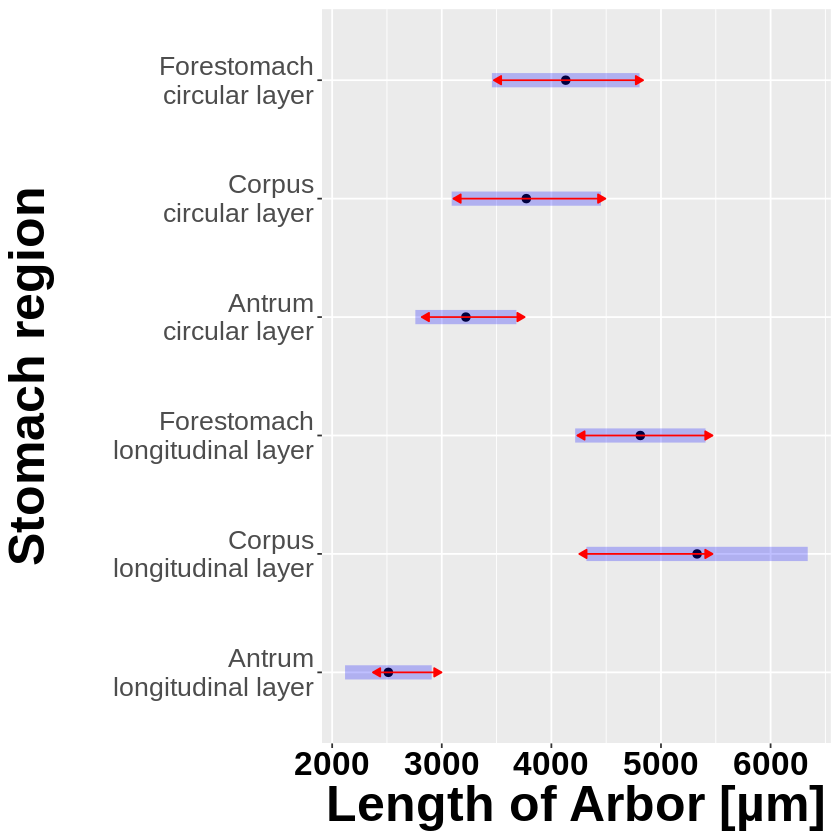

In [76]:
###################################################################
## Plot relevant mariginal means plots
## Pick the feature number
i=2
###################################################################
gg_plot_f[[i]]



In [77]:
### Save the plot
plot.name <- paste(colnames(spatial.data.sub)[i],"-","Marginal means.pdf")
plot.name
ggsave(plot.name)

[1] "Length of Arbor (µm) - Marginal means.pdf"

Saving 6.67 x 6.67 in image


## Comparisons within the groups
Biologically, it probably makes more sense to compare the values with in muscule layers, not between them.

In [78]:
tmp.var <- colnames(spatial.data.df)[1:8]
fit2 <- fit2.em <- fit2.cont <- list()

for (i in 1:8) {
    if (i < 5){
    fit2[[i]] <-    lm(log(get(tmp.var[i])) ~ Region*Layer, data = spatial.data.df)    ##### for some feature the transformation should be "log"
    fit2[[i]] <-    update(ref_grid(fit2[[i]]), tran = "log")                      
  } else {
    fit2[[i]] <-    lm(sqrt(get(tmp.var[i])) ~ Region*Layer - 1, data = spatial.data.df)    ##### for some feature the transformation should be "sqrt"
    fit2[[i]] <-    update(ref_grid(fit2[[i]]), tran = "sqrt")                      
  }
  fit2.em[[i]] <- emmeans(fit2[[i]], ~ Region | Layer, type="reponse")  
}

for (i in 1:8) {
    fit2.cont[[i]] <- contrast(pairs(fit2.em[[i]]), type="none")#, weights="proportional") 
}


### Output the result to the table
Pick the relevant feature number (from 1 to 8) and asign to _i_.

In [79]:
i=8
fit.tmp <- as.data.frame(fit2.cont[[i]]) %>% mutate_if(is.numeric, round, digits = 5)
tables_rjs(fit.tmp, jupyter = TRUE)

## Spatial interpretation/visualization of the data

In [80]:
#stom.win <- content(GET("https://www.dropbox.com/s/u1nzn4ztwqa41am/Stomach03.png?dl=1"))
stom.win <- readPNG("~/inputs/input_1/Stomach_contour.png")
stom.win.mask <- matrix(ncol=ncol(stom.win[,,1]), nrow=nrow(stom.win[,,1]), data=as.logical(stom.win[,,1]), byrow=F)

stom.owin <- owin(mask=stom.win.mask)
stom.poly <- as.polygonal(stom.owin)

spatial.data.xy <- data.frame(X=round(spatial.data.s[,1]*930.05/100+25,0), Y=round(spatial.data.s[,2]*700.05/100+82,0))


### Use the subset of the data to create point pattern for smoothing and analysis

In [81]:
##################################################################################### 
#### create point-patterns

sp.dat.circ <- subset(spatial.data.s, layer=="circ")
sp.dat.circ[c(3,4,5,6)] <- scale(log(sp.dat.circ[c(3,4,5,6)]))
sp.dat.circ[c(7,8,9,10)] <- scale(sqrt(sp.dat.circ[c(7,8,9,10)]))
sp.xy.circ <- subset(spatial.data.xy, spatial.data.s$layer=="circ")
spat.test.circ <- ppp(x=sp.xy.circ[,1], y=sp.xy.circ[,2], marks=sp.dat.circ[c(3:10)], window=stom.poly, checkdup=F)
spat.test.circ <- (shift(spat.test.circ, origin="bottomleft"))

sp.dat.lon <- subset(spatial.data.s, layer=="lon")
sp.dat.lon[c(3,4,5,6)] <- scale(log(sp.dat.lon[c(3,4,5,6)]))
sp.dat.lon[c(7,8,9,10)] <- scale(sqrt(sp.dat.lon[c(7,8,9,10)]))
sp.xy.lon <- subset(spatial.data.xy, spatial.data.s$layer=="lon")
spat.test.lon <- ppp(x=sp.xy.lon[,1], y=sp.xy.lon[,2], marks=sp.dat.lon[c(3:10)], window=stom.poly, checkdup=F)
spat.test.lon <- (shift(spat.test.lon, origin="bottomleft"))


## Plot the smoothed map of a feature value
Pick the feature of interest and assign to _i_ (from 1 to 8)

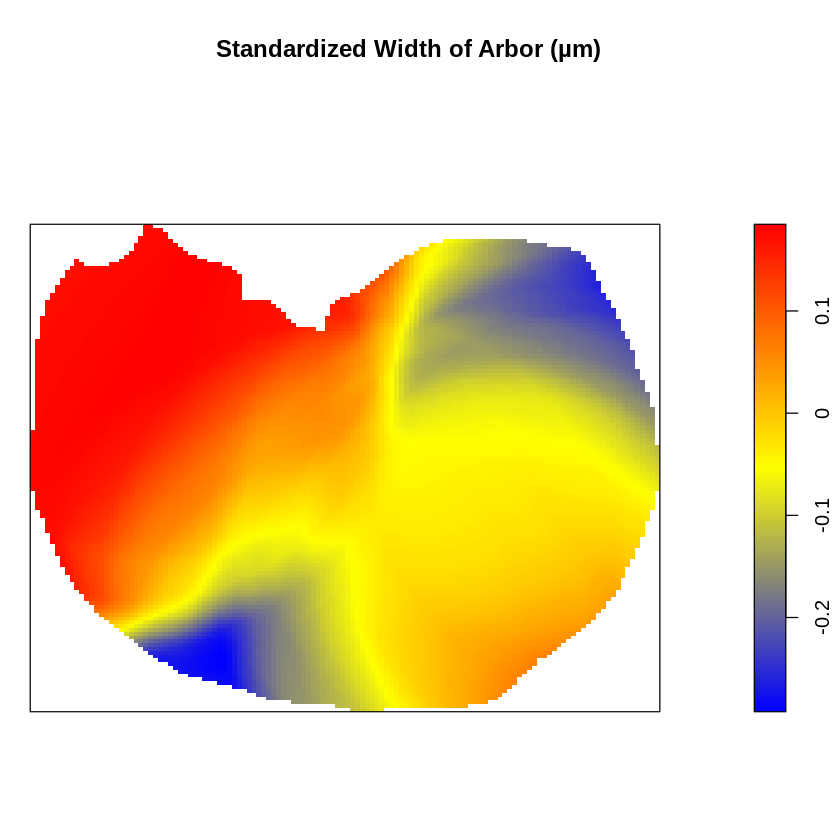

In [82]:
i=3  ### i is the feature number. Pick from 1 to 8

par(mar=c(0,0,4,1))
spat.smooth <- Smooth(spat.test.lon, sigma=160, at="pixels", kernel="epanechnikov", diggle=T, geometric=F, main="")
plot(spat.smooth[[i]], col = colorRampPalette(c("blue", "yellow", "red"))(256), main=paste("Standardized", names(spat.smooth[i])))


In [83]:
### Save the plot

plot.name <- paste(colnames(spatial.data.sub)[i],"-","Smoothed feature map.pdf")
pdf(plot.name)
plot(spat.smooth[[i]], col = colorRampPalette(c("blue", "yellow", "red"))(256), main=paste("Standardized", names(spat.smooth[i])))
dev.off()

png 
  2

Warning message in is.multitype.ppp(x):
“some mark values are NA in the point pattern x”

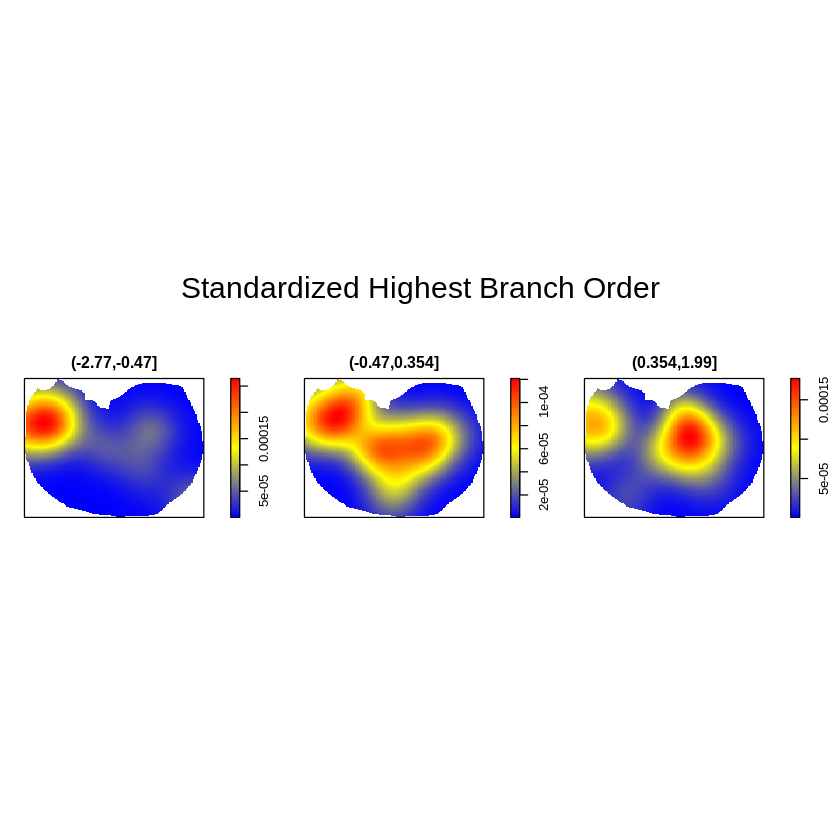

In [84]:
#### pick the feature of interest represented by variable i
i=5

spat.test.circ.temp <- spat.test.circ
title=paste("Standardized", names(marks(spat.test.circ.temp, drop=F)[i]))
marks(spat.test.circ.temp, drop=F) <- marks(spat.test.circ.temp, drop=F)[i]
breaks.hist <- quantile(marks(spat.test.circ.temp), probs = c(0, 0.33, 0.66, 1)) 
spat.test.circ.temp.cut <- split(cut.ppp(spat.test.circ.temp, breaks=breaks.hist))
plot(density(spat.test.circ.temp.cut), col = colorRampPalette(c("blue", "yellow", "red"))(256), main=title)


Warning message in is.multitype.ppp(x):
“some mark values are NA in the point pattern x”

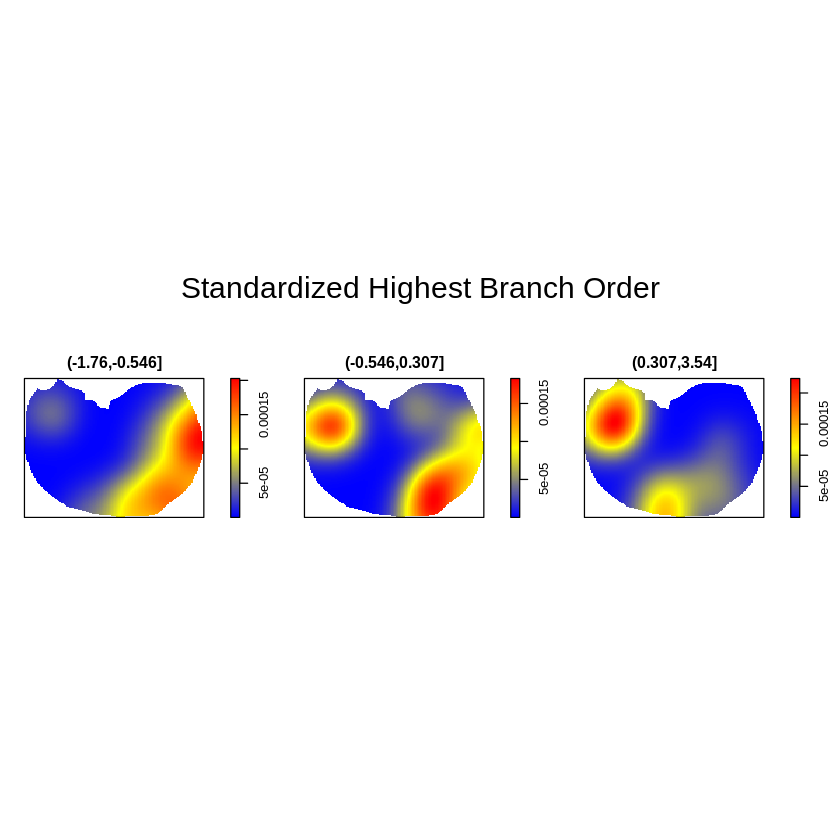

In [85]:
spat.test.lon.temp <- spat.test.lon
title=paste("Standardized", names(marks(spat.test.lon.temp, drop=F)[i]))
marks(spat.test.lon.temp, drop=F) <- marks(spat.test.lon.temp, drop=F)[i]
breaks.hist <- quantile(marks(spat.test.lon.temp), probs = c(0, 0.33, 0.66, 1)) 
spat.test.lon.temp.cut <- split(cut.ppp(spat.test.lon.temp, breaks=breaks.hist))
plot(density(spat.test.lon.temp.cut), col = colorRampPalette(c("blue", "yellow", "red"))(256), main=title)

